Covariance matrix has been calculated and saved.


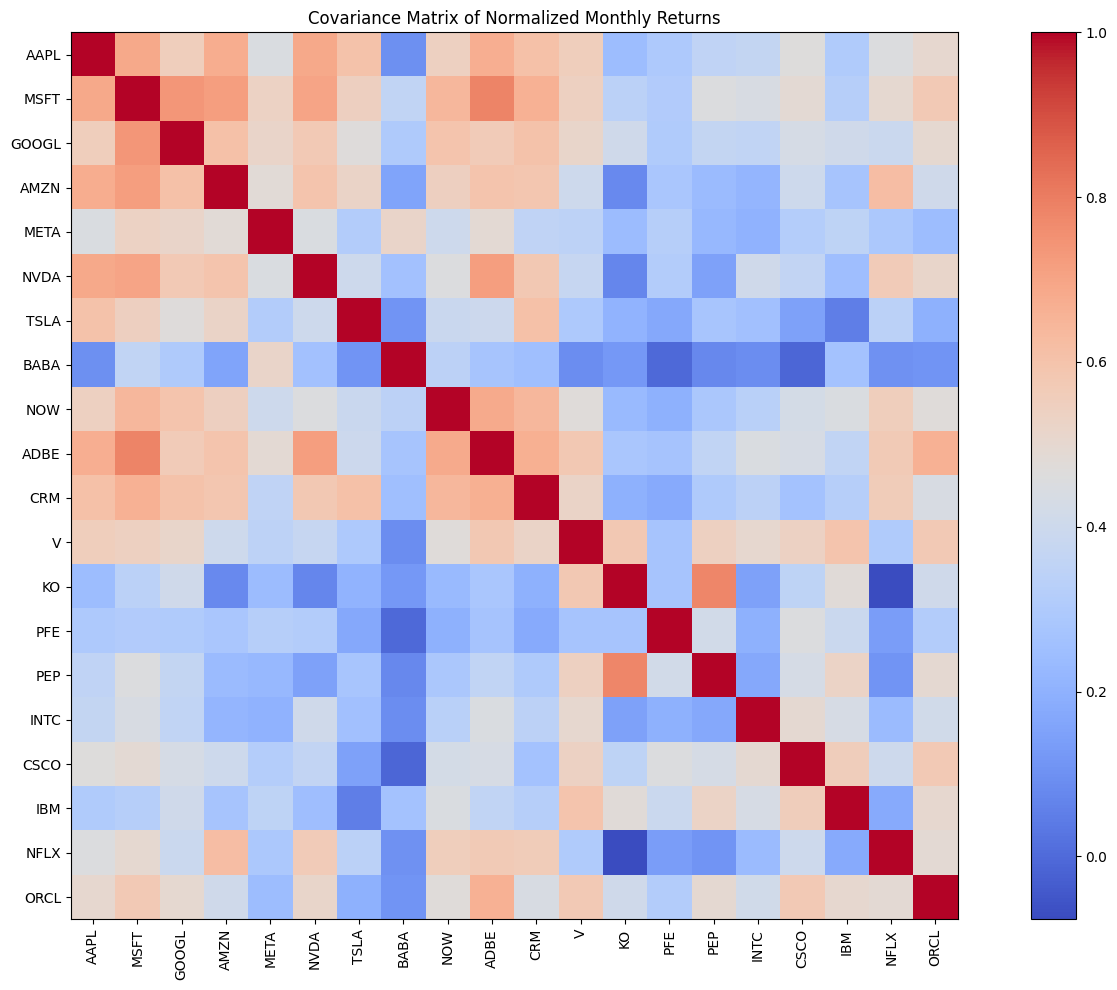


Running Basic EP...
Run 1/10: Best Fitness (Sharpe Ratio) = 0.3057
Run 2/10: Best Fitness (Sharpe Ratio) = 0.3049
Run 3/10: Best Fitness (Sharpe Ratio) = 0.3110
Run 4/10: Best Fitness (Sharpe Ratio) = 0.3166
Run 5/10: Best Fitness (Sharpe Ratio) = 0.3075
Run 6/10: Best Fitness (Sharpe Ratio) = 0.3204
Run 7/10: Best Fitness (Sharpe Ratio) = 0.3086
Run 8/10: Best Fitness (Sharpe Ratio) = 0.3111
Run 9/10: Best Fitness (Sharpe Ratio) = 0.3087
Run 10/10: Best Fitness (Sharpe Ratio) = 0.3039
Average Best Fitness (Sharpe Ratio) over 10 runs: 0.3098 ± 0.0050


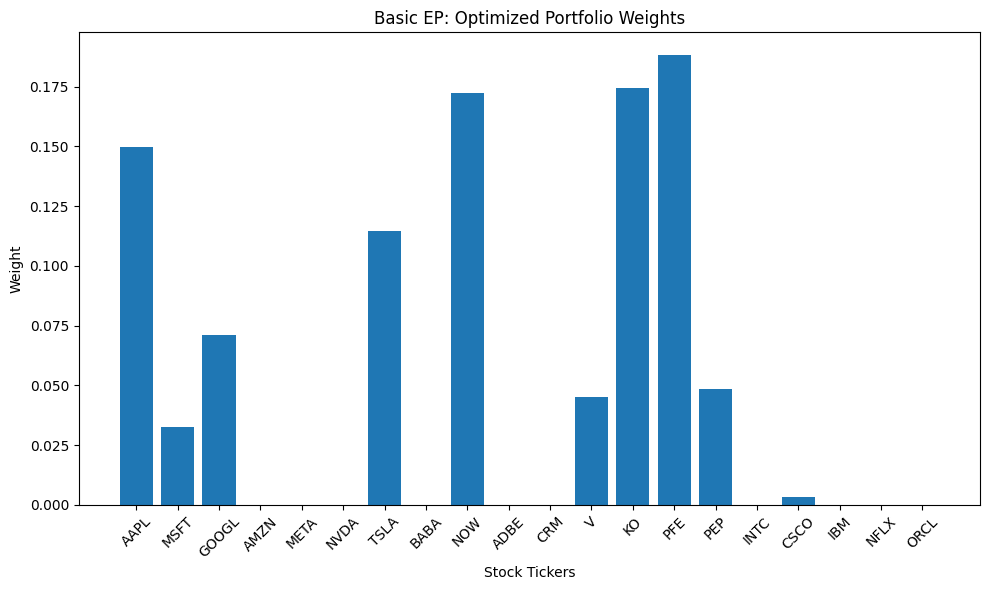


Running Advanced EP...
Run 1/10: Best Fitness (Sharpe Ratio) = 0.3202
Run 2/10: Best Fitness (Sharpe Ratio) = 0.3165
Run 3/10: Best Fitness (Sharpe Ratio) = 0.3133
Run 4/10: Best Fitness (Sharpe Ratio) = 0.3142
Run 5/10: Best Fitness (Sharpe Ratio) = 0.3113
Run 6/10: Best Fitness (Sharpe Ratio) = 0.3115
Run 7/10: Best Fitness (Sharpe Ratio) = 0.3053
Run 8/10: Best Fitness (Sharpe Ratio) = 0.3149
Run 9/10: Best Fitness (Sharpe Ratio) = 0.3083
Run 10/10: Best Fitness (Sharpe Ratio) = 0.3068
Average Best Fitness (Sharpe Ratio) over 10 runs: 0.3122 ± 0.0043


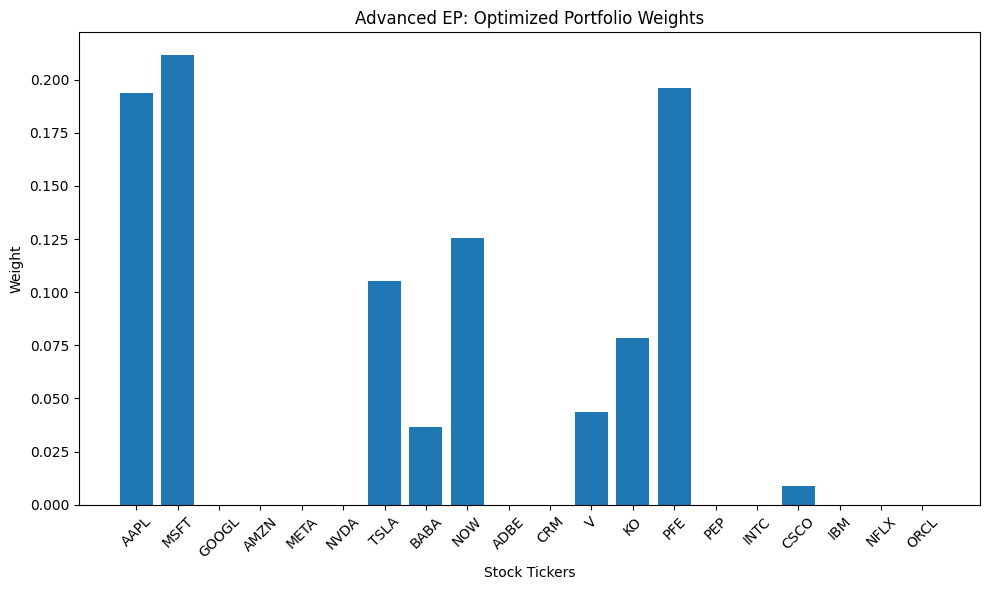


Running Basic ES...
Run 1/10: Best Fitness (Sharpe Ratio) = 0.3068
Run 2/10: Best Fitness (Sharpe Ratio) = 0.3045
Run 3/10: Best Fitness (Sharpe Ratio) = 0.3050
Run 4/10: Best Fitness (Sharpe Ratio) = 0.3126
Run 5/10: Best Fitness (Sharpe Ratio) = 0.3094
Run 6/10: Best Fitness (Sharpe Ratio) = 0.3135
Run 7/10: Best Fitness (Sharpe Ratio) = 0.3114
Run 8/10: Best Fitness (Sharpe Ratio) = 0.3071
Run 9/10: Best Fitness (Sharpe Ratio) = 0.3119
Run 10/10: Best Fitness (Sharpe Ratio) = 0.3028
Average Best Fitness (Sharpe Ratio) over 10 runs: 0.3085 ± 0.0036


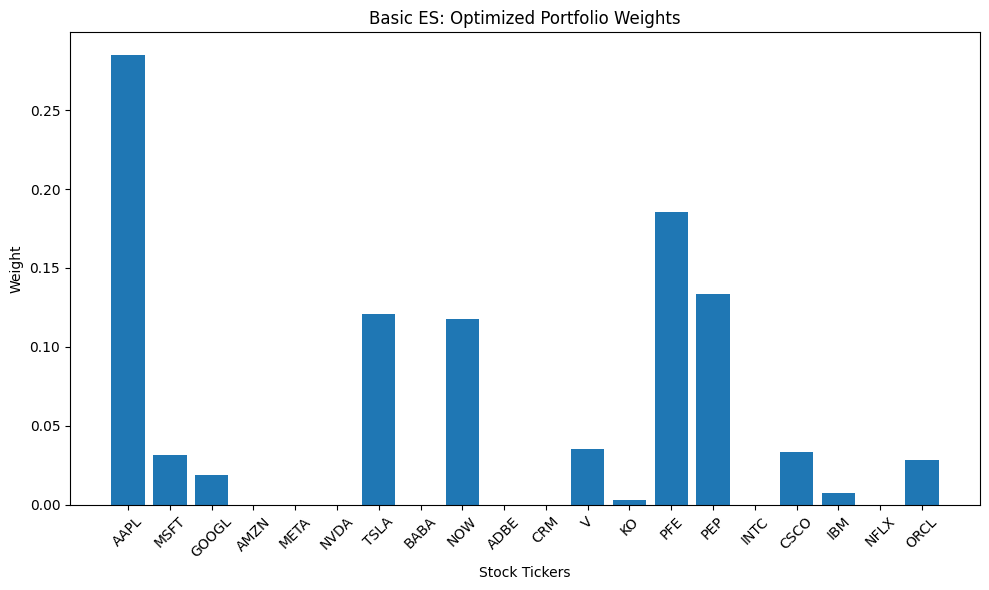


Running Advanced ES...
Run 1/10: Best Fitness (Sharpe Ratio) = 0.3115
Run 2/10: Best Fitness (Sharpe Ratio) = 0.3229
Run 3/10: Best Fitness (Sharpe Ratio) = 0.3082
Run 4/10: Best Fitness (Sharpe Ratio) = 0.3129
Run 5/10: Best Fitness (Sharpe Ratio) = 0.3099
Run 6/10: Best Fitness (Sharpe Ratio) = 0.3117
Run 7/10: Best Fitness (Sharpe Ratio) = 0.3110
Run 8/10: Best Fitness (Sharpe Ratio) = 0.3091
Run 9/10: Best Fitness (Sharpe Ratio) = 0.3019
Run 10/10: Best Fitness (Sharpe Ratio) = 0.3057
Average Best Fitness (Sharpe Ratio) over 10 runs: 0.3105 ± 0.0052


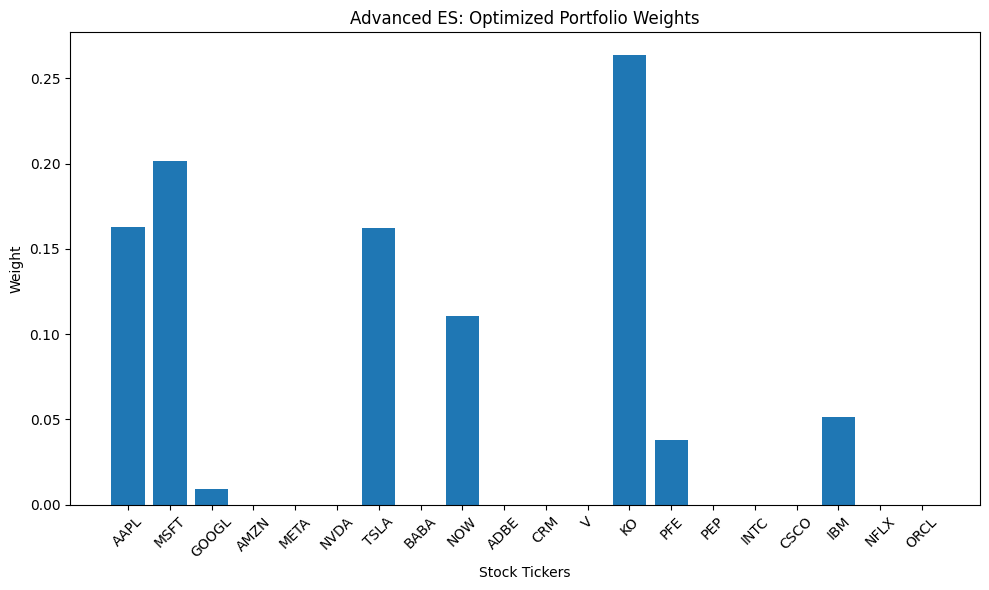


Running (μ + λ) ES...
Run 1/10: Best Fitness (Sharpe Ratio) = 0.3219
Run 2/10: Best Fitness (Sharpe Ratio) = 0.3269
Run 3/10: Best Fitness (Sharpe Ratio) = 0.3235
Run 4/10: Best Fitness (Sharpe Ratio) = 0.3178
Run 5/10: Best Fitness (Sharpe Ratio) = 0.3230
Run 6/10: Best Fitness (Sharpe Ratio) = 0.3191
Run 7/10: Best Fitness (Sharpe Ratio) = 0.3257
Run 8/10: Best Fitness (Sharpe Ratio) = 0.3228
Run 9/10: Best Fitness (Sharpe Ratio) = 0.3210
Run 10/10: Best Fitness (Sharpe Ratio) = 0.3213
Average Best Fitness (Sharpe Ratio) over 10 runs: 0.3223 ± 0.0026


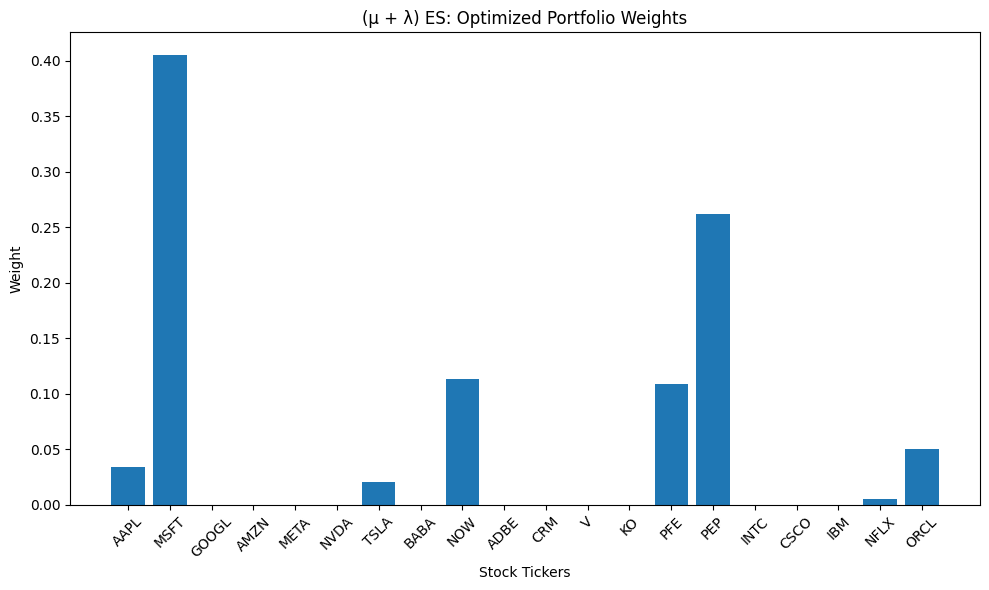


Running (μ, λ) ES...
Run 1/10: Best Fitness (Sharpe Ratio) = 0.3215
Run 2/10: Best Fitness (Sharpe Ratio) = 0.3227
Run 3/10: Best Fitness (Sharpe Ratio) = 0.3224
Run 4/10: Best Fitness (Sharpe Ratio) = 0.3242
Run 5/10: Best Fitness (Sharpe Ratio) = 0.3263
Run 6/10: Best Fitness (Sharpe Ratio) = 0.3226
Run 7/10: Best Fitness (Sharpe Ratio) = 0.3238
Run 8/10: Best Fitness (Sharpe Ratio) = 0.3243
Run 9/10: Best Fitness (Sharpe Ratio) = 0.3249
Run 10/10: Best Fitness (Sharpe Ratio) = 0.3262
Average Best Fitness (Sharpe Ratio) over 10 runs: 0.3239 ± 0.0015


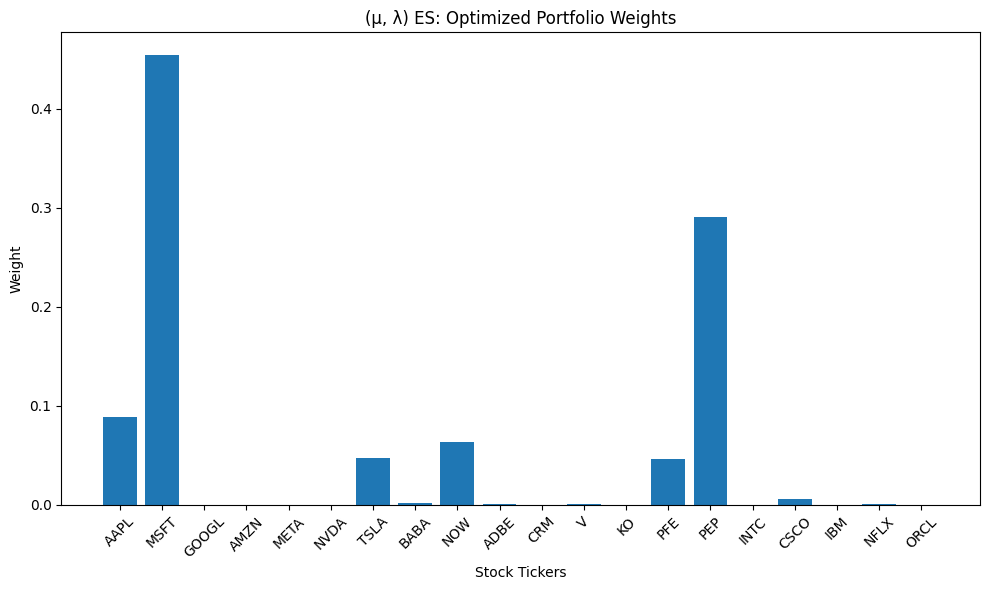

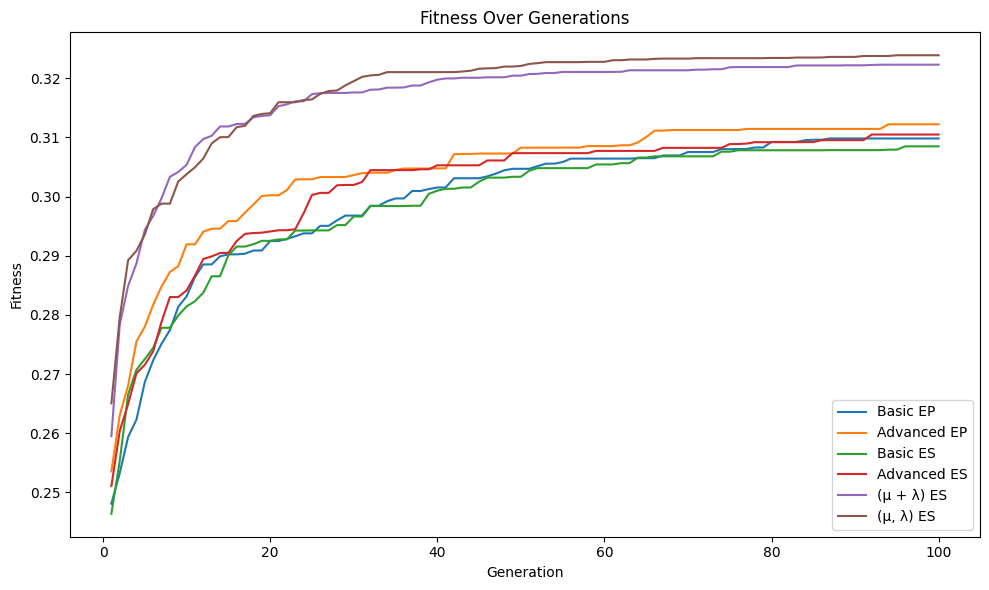


Summary of Algorithm Performance:
     Algorithm  Average Best Fitness  Std Dev of Best Fitness
0     Basic EP              0.309829                 0.004958
1  Advanced EP              0.312225                 0.004335
2     Basic ES              0.308496                 0.003584
3  Advanced ES              0.310495                 0.005159
4   (μ + λ) ES              0.322299                 0.002616
5    (μ, λ) ES              0.323893                 0.001537

Optimized Portfolio Weights for Each Algorithm:
     Algorithm      AAPL      MSFT     GOOGL  AMZN     META      NVDA  \
0     Basic EP  0.149710  0.032427  0.071205   0.0  0.00000  0.000000   
1  Advanced EP  0.193858  0.211696  0.000000   0.0  0.00000  0.000000   
2     Basic ES  0.285009  0.031217  0.018958   0.0  0.00000  0.000000   
3  Advanced ES  0.162752  0.201538  0.009107   0.0  0.00000  0.000000   
4   (μ + λ) ES  0.034359  0.405432  0.000000   0.0  0.00000  0.000000   
5    (μ, λ) ES  0.088204  0.454444  0.000000

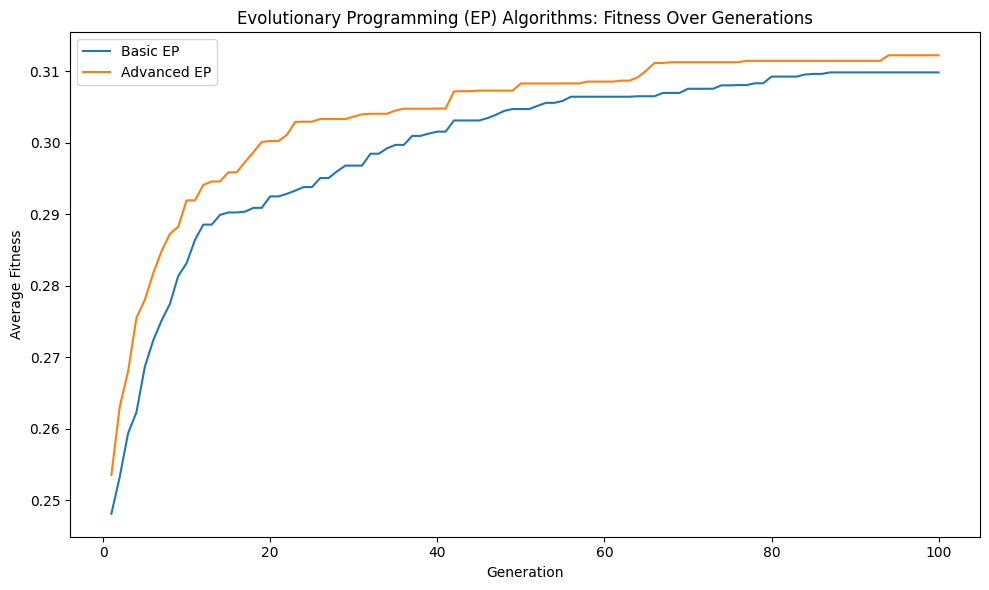


Evolutionary Strategies (ES) Algorithms Comparison:
     Algorithm  Average Best Fitness  Std Dev of Best Fitness
0     Basic ES              0.308496                 0.003584
1  Advanced ES              0.310495                 0.005159


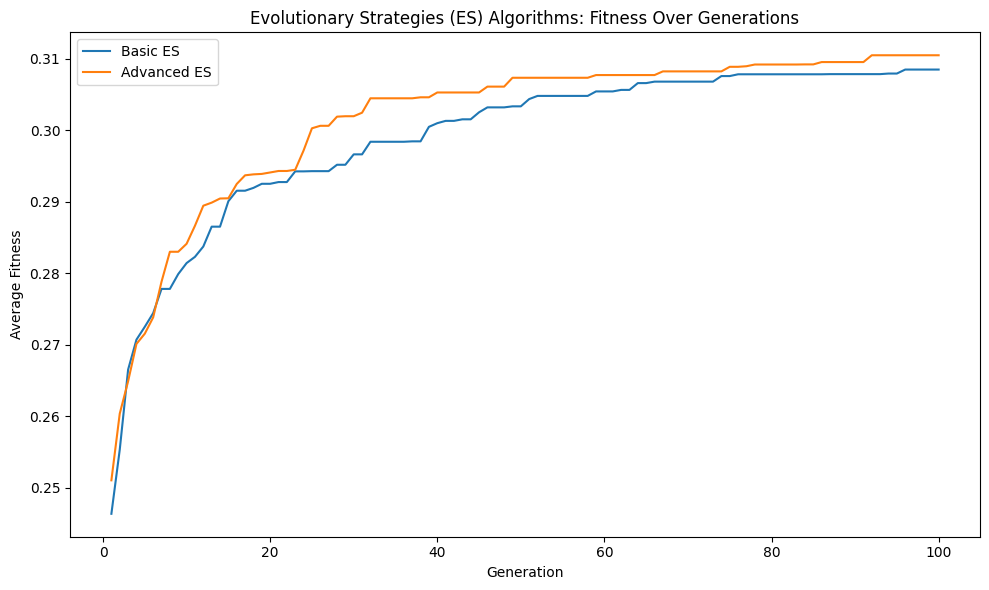


(μ + λ) vs (μ, λ) ES Algorithms Comparison:
    Algorithm  Average Best Fitness  Std Dev of Best Fitness
0  (μ + λ) ES              0.322299                 0.002616
1   (μ, λ) ES              0.323893                 0.001537


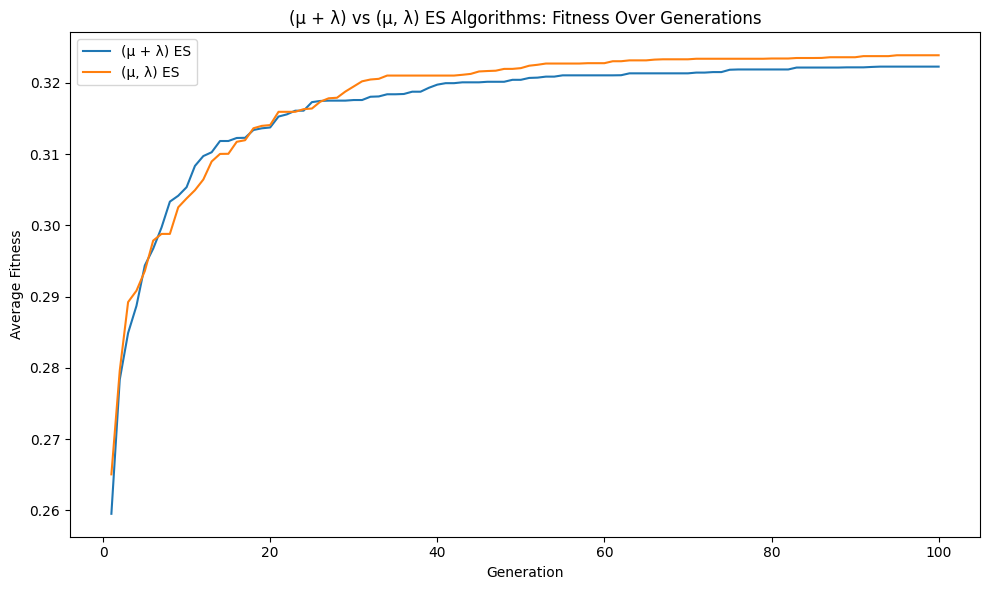

In [ ]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# listing of stock tickers
stocks = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'BABA', 'NOW', 'ADBE',
    'CRM', 'V', 'KO', 'PFE', 'PEP', 'INTC', 'CSCO', 'IBM', 'NFLX', 'ORCL'
]

# all the historical data period
start_period = '2018-01-01'
end_period = '2022-12-31'

def create_folder():
    """
    creates a folder named 'Stocks' if it doesn't exist

    have a folder used to store downloaded stock data and computed results
    """
    if not os.path.exists('Stocks'):
        os.makedirs('Stocks')

def download_stock_dataset(stock):
    """
    downloads historical stock data and saves it as a CSV file

    paramters used:
    stock (str): stock ticker symbol

    this function uses the yfinance library to collect historical data for the specified stock
    and saves it to the Stocks-folder
    """
    try:
        data = yf.download(stock, start=start_period, end=end_period, progress=False)
        data.to_csv(f'Stocks/{stock}.csv')
    except Exception as e:
        print(f'Error downloading data for {stock}: {e}')

def calculate_monthly_returns(stock):
    """
    calculates monthly returns from daily adjusted close prices and saves them

    paramters used:
    stock (str): stock ticker symbol

    returns back
    monthly returns for the stock (in Series)

    function reads the daily adjusted close prices, resamples them to end-of-month frequency,
    calculates the percentage change to get monthly returns, and saves them to a CSV file
    """
    try:
        data = pd.read_csv(f'Stocks/{stock}.csv', parse_dates=['Date'], index_col='Date')
        # resample daily data to end of month and calculate percentage change. used ME because M is depreecated
        monthly_returns = data['Adj Close'].resample('ME').ffill().pct_change()
        monthly_returns.to_csv(f'Stocks/{stock}_monthly_returns.csv', header=['Monthly Return'])
        return monthly_returns
    except Exception as e:
        print(f'an error occured when calculating monthly returns for {stock}: {e}')
        return None

def calculate_covariance_matrix():
    """
    calculates and saves the covariance matrix of monthly returns for all stocks

    function reads the monthly returns of all stocks, computes the covariance matrix,
    saves it to a CSV file, and plots the covariance matrix as a heatmap(it is normalized)
    """
    try:
        monthly_returns_data = pd.DataFrame()
        for stock in stocks:
            data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
            monthly_returns_data[stock] = data['Monthly Return']
        
        # calculate covariance matrix of monthly returns
        covariance_matrix = monthly_returns_data.cov()
        covariance_matrix.to_csv('Stocks/covariance_matrix.csv')
        print('Covariance matrix has been calculated and saved.')

        # normalizing monthly returns only for plotting purposes
        normalized_returns = (monthly_returns_data - monthly_returns_data.mean()) / monthly_returns_data.std()

        # plotting the covariance matrix of normalized returns
        normalized_covariance_matrix = normalized_returns.cov()

        plt.figure(figsize=(15, 10))
        plt.imshow(normalized_covariance_matrix, cmap='coolwarm', interpolation='none')
        plt.colorbar()
        plt.xticks(range(len(stocks)), stocks, rotation=90)
        plt.yticks(range(len(stocks)), stocks)
        plt.title('Covariance Matrix of Normalized Monthly Returns')
        plt.tight_layout()
        plt.savefig('Stocks/covariance_matrix_plot.png')
        plt.show()

    except Exception as e:
        print(f'An error when calculating covariance matrix: {e}')


def load_monthly_returns():
    """
    loading monthly returns for all stocks into a dataframe

    returns back
    dataFrame containing monthly returns of all stocks

    function reads the monthly returns CSV files for each stock and combines them into a single dataFrame
    """
    monthly_returns_data = pd.DataFrame()
    for stock in stocks:
        data = pd.read_csv(f'Stocks/{stock}_monthly_returns.csv', parse_dates=['Date'], index_col='Date')
        monthly_returns_data[stock] = data['Monthly Return']
    return monthly_returns_data

def calculate_fitness(weights, returns_data, covariance_matrix):
    """
    calculates the Sharpe Ratio of a portfolio given its weights.

    paramters used:
    weights: Array of portfolio weights
    returns_data (dataframe): dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): Covariance matrix of the returns data

    returns back
    float: The Sharpe Ratio of the portfolio

    function computes the expected return and variance of the portfolio,
    then calculates the Sharpe Ratio as the return divided by the standard deviation (risk)
    """
    # calculatioin expected portfolio return
    portfolio_return = np.dot(weights, returns_data.mean())
    # calculatiom portfolio variance using the provided covariance matrix
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    # avoiding division by zero
    if portfolio_variance == 0:
        return 0
    # calculate with Sharpe Ratio
    sharpe_ratio = portfolio_return / np.sqrt(portfolio_variance)
    return sharpe_ratio


def mutate(weights, mutation_rate):
    """
    mutates a solution by adding Gaussian noise for the the weights

    paramters used:
    weights (array): current portfolio weights
    mutation_rate (float): standard deviation of the Gaussian noise

    returns back
    new portfolio weights after mutation, normalized to sum to 1. As an array

    function adds Gaussian noise to each weight, clips negative values to zero,
    and normalizes the weights so they sum to one
    """
    new_weights = weights + np.random.normal(0, mutation_rate, len(weights))
    new_weights = np.clip(new_weights, 0, None)
    # Normalize weights to sum to 1
    if new_weights.sum() == 0:
        new_weights = np.ones_like(new_weights) / len(new_weights)
    else:
        new_weights = new_weights / new_weights.sum()  # Ensure weights sum to 1
    return new_weights

def mutate_advanced(weights, mutation_rate, mutation_adaptive_factor):
    """
    mutating a solution with an adaptive mutation rate.

    paramters used:
    weights (array): current portfolio weights
    mutation_rate (float): base mutation rate
    mutation_adaptive_factor (float): Adaptive factor for mutation rate

    returns back
    new portfolio weights after mutation, normalized to sum to 1 as an array

    function adapts the mutation rate for each weight individually and then mutates the weights
    """
    # adaptive mutation rate for each weight using an exponential function to ensure positivity
    adaptive_mutation = mutation_rate * np.exp(np.random.normal(0, mutation_adaptive_factor, len(weights)))
    new_weights = weights + np.random.normal(0, adaptive_mutation, len(weights))
    new_weights = np.clip(new_weights, 0, None)
    # normalized weights for it to sum to 1
    if new_weights.sum() == 0:
        new_weights = np.ones_like(new_weights) / len(new_weights)
    else:
        new_weights = new_weights / new_weights.sum()
    return new_weights


def tournament_selection(population, fitnesses, num_selections, tournament_size=3):
    """
    performs tournament selection on a population

    paramters used:
    population: list of individuals in the population
    fitnesses (list): corresponding fitness values of the individuals
    num_selections (int): number of individuals to select
    tournament_size (int): number of individuals competing in each tournament

    returns back
    list: Selected individuals for the next generation.

    function selects individuals based on their fitness using tournament selection strategy
    """
    selected = []
    for _ in range(num_selections):
        participants = np.random.choice(len(population), tournament_size, replace=False)
        best_participant = max(participants, key=lambda idx: fitnesses[idx])
        selected.append(population[best_participant])
    return selected

def discrete_recombination(parent1, parent2):
    """
    performing a discrete recombination between two parent individuals

    paramters used:
    parent1 (tuple): first parent (weights, sigma).
    parent2 (tuple): second parent (weights, sigma).

    returns back
    tuple: child individual (weights, sigma) after recombination.

    function creates a child by randomly selecting genes (weights and sigma) from each parent
    """
    child_weights = np.where(np.random.rand(len(stocks)) < 0.5, parent1[0], parent2[0])
    child_sigma = np.where(np.random.rand(len(stocks)) < 0.5, parent1[1], parent2[1])
    return (child_weights, child_sigma)

def plot_fitness_over_generations(fitness_over_time_list, labels, title, file_name):
    """
    plotting the average fitness over generations for all the algorithms

    paramters used:
    fitness_over_time_list: List of fitness histories from different algorithms
    labels (list): Labels for each algorithm
    title (str): Title of the plot
    file_name (str): File name to save the plot

    function plots and saves the fitness progression of each algorithm over generations
    """
    plt.figure(figsize=(10, 6))
    for fitness_histories, label in zip(fitness_over_time_list, labels):
        avg_fitness = np.mean(fitness_histories, axis=0)
        plt.plot(range(1, len(avg_fitness) + 1), avg_fitness, label=label)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()


def plot_optimized_weights(weights, title):
    """
    plotting the optimized portfolio weights

    paramters used:
    weights: Portfolio weights as an array
    title (str): Title of the plot

    function creates a bar chart showing the weight of each stock in the optimized portfolio
    """
    plt.figure(figsize=(10, 6))
    plt.bar(stocks, weights)
    plt.xlabel('Stock Tickers')
    plt.ylabel('Weight')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def run_algorithm_multiple_times(algorithm_func, returns_data, covariance_matrix, num_runs, **kwargs):
    """
    running an algorithm multiple times and collects the results

    paramters used:
    algorithm_func:  the chosen Evolutionary algorithm function to run
    returns_data (dataframe): dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): Covariance matrix of the returns data
    num_runs (int): number of runs to perform
    **kwargs: additional parameters for the algorithm function

    returns back
    A dictionary containing detailed results:
        - best_solutions: list of best solutions from each run
        - best_fitnesses: list of best fitness values from each run
        - fitness_histories: list of fitness progression over generations for each run
        - avg_fitness_over_time: average fitness over generations across runs
        - std_fitness_over_time: standard deviation of fitness over generations across runs
        - avg_best_fitness: average of the best fitness values across runs
        - std_best_fitness: standard deviation of the best fitness values across runs
    """
    best_solutions = []
    best_fitnesses = []
    fitness_histories = []

    for run in range(num_runs):
        best_solution, best_fitness, fitness_over_time = algorithm_func(returns_data, covariance_matrix, **kwargs)
        best_solutions.append(best_solution)
        best_fitnesses.append(best_fitness)
        fitness_histories.append(fitness_over_time)
        print(f'Run {run + 1}/{num_runs}: Best Fitness (Sharpe Ratio) = {best_fitness:.4f}')

    avg_best_fitness = np.mean(best_fitnesses)
    std_best_fitness = np.std(best_fitnesses)
    print(f'Average Best Fitness (Sharpe Ratio) over {num_runs} runs: {avg_best_fitness:.4f} ± {std_best_fitness:.4f}')

    # calculating average and standard deviation of fitness over generations
    avg_fitness_over_time = np.mean(fitness_histories, axis=0)
    std_fitness_over_time = np.std(fitness_histories, axis=0)

    return {
        'best_solutions': best_solutions,
        'best_fitnesses': best_fitnesses,
        'fitness_histories': fitness_histories,
        'avg_fitness_over_time': avg_fitness_over_time,
        'std_fitness_over_time': std_fitness_over_time,
        'avg_best_fitness': avg_best_fitness,
        'std_best_fitness': std_best_fitness
    }


def create_results_table(all_results):
    """
    creating a table summarizing the performance of each algorithm

    paramters used:
    all_results: List of dictionaries containing results for each algorithm
    """
    data = []
    for entry in all_results:
        name = entry['name']
        avg_best_fitness = entry['results']['avg_best_fitness']
        std_best_fitness = entry['results']['std_best_fitness']
        data.append([name, avg_best_fitness, std_best_fitness])

    results_df = pd.DataFrame(data, columns=['Algorithm', 'Average Best Fitness', 'Std Dev of Best Fitness'])
    print('\nSummary of Algorithm Performance:')
    print(results_df)

    # saviong the table to a CSV file
    results_df.to_csv('Stocks/algorithm_performance_summary.csv', index=False)


def create_weights_table(all_results):
    """
    creating a table of optimized weights for each algorithm

    paramters used:
    all_results: List of dictionaries containing results for each algorithm
    """
    weights_data = []
    for entry in all_results:
        name = entry['name']
        best_solution = entry['results']['best_solutions'][-1]
        if isinstance(best_solution, tuple):
            # extrationg weights if best_solution is a tuple (weights, sigma)
            weights = best_solution[0]
        else:
            weights = best_solution
        weights_data.append([name] + list(weights))

    columns = ['Algorithm'] + stocks
    weights_df = pd.DataFrame(weights_data, columns=columns)
    print('\nOptimized Portfolio Weights for Each Algorithm:')
    print(weights_df)

    # finally saving the table to a CSV file
    weights_df.to_csv('Stocks/optimized_weights_summary.csv', index=False)

def compare_algorithms(algorithms_list, title):
    """
    genearting a comparison table and plots for a list of algorithms

    paramters used:
    algorithms_list: list of algorithm entries to compare
    title (str): title for the comparison section.
    """
    print(f'\n{title} Comparison:')

    # creating a dataframe summarizing the performance
    data = []
    for entry in algorithms_list:
        name = entry['name']
        avg_best_fitness = entry['results']['avg_best_fitness']
        std_best_fitness = entry['results']['std_best_fitness']
        data.append([name, avg_best_fitness, std_best_fitness])

    comparison_df = pd.DataFrame(data, columns=['Algorithm', 'Average Best Fitness', 'Std Dev of Best Fitness'])
    print(comparison_df)

    # plotting the average fitness over generations for these algorithms
    plt.figure(figsize=(10, 6))
    for entry in algorithms_list:
        name = entry['name']
        avg_fitness = entry['results']['avg_fitness_over_time']
        plt.plot(range(1, len(avg_fitness) + 1), avg_fitness, label=name)
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.title(f'{title}: Fitness Over Generations')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Stocks/{title.replace(" ", "_")}_comparison_plot.png')
    plt.show()

def comparative_analysis(all_results):
    """
    performing comparative analysis between algorithms and generates visualizations

    paramters used:
    all_results: list of dictionaries containing results for each algorithm
    """
    # seperating the algorithms into categories
    ep_algorithms = [entry for entry in all_results if 'EP' in entry['name']]
    es_algorithms = [entry for entry in all_results if 'ES' in entry['name'] and 'μ' not in entry['name']]
    mu_lambda_algorithms = [entry for entry in all_results if 'μ' in entry['name']]

    # comparing basic vs advanced EP
    compare_algorithms(ep_algorithms, 'Evolutionary Programming (EP) Algorithms')

    # comparing basic vs advanced ES
    compare_algorithms(es_algorithms, 'Evolutionary Strategies (ES) Algorithms')

    # comparing (μ + λ) vs (μ, λ) ES
    compare_algorithms(mu_lambda_algorithms, '(μ + λ) vs (μ, λ) ES Algorithms')


def basic_evolutionary_programming(returns_data, covariance_matrix, population_size, n_generations, mutation_rate):
    """
    implementation of the Basic Evolutionary Programming algorithm.

    paramters used:
    returns_data: dataFrame of monthly returns for all stocks
    covariance_matrix (dataframe): covariance matrix of the returns data
    population_size (int): number of individuals in the population
    n_generations (int): number of generations to evolve
    mutation_rate (float): mutation rate for generating offspring

    returns back
    tuple: (best_solution, best_fitness, fitness_over_time)
        - best_solution (array): best portfolio weights found
        - best_fitness (float): best fitness value achieved
        - fitness_over_time (list): fitness of the best individual in each generation
    """
    # initializion of  population with random weights (weights sum to 1)
    population = []
    for _ in range(population_size):
        individual = np.random.dirichlet(np.ones(len(stocks)))
        population.append(individual)

    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []

    for generation in range(n_generations):
        # generating offspring by mutating each individual
        offspring = []
        for individual in population:
            new_individual = mutate(individual, mutation_rate)
            offspring.append(new_individual)

        # combining parents and offspring
        combined_population = population + offspring
        combined_fitnesses = [calculate_fitness(ind, returns_data, covariance_matrix) for ind in combined_population]

        # here is selection: using tournament selection to select next generation
        population = tournament_selection(combined_population, combined_fitnesses, population_size, tournament_size=3)

        # make sure population size remains constant
        assert len(population) == population_size, "Population size has changed unexpectedly."

        # updating the best solution
        fitnesses = [calculate_fitness(ind, returns_data, covariance_matrix) for ind in population]
        max_fitness_idx = np.argmax(fitnesses)
        if fitnesses[max_fitness_idx] > best_fitness:
            best_fitness = fitnesses[max_fitness_idx]
            best_solution = population[max_fitness_idx]

        fitness_over_time.append(best_fitness)

    return best_solution, best_fitness, fitness_over_time


def advanced_evolutionary_programming(returns_data, covariance_matrix, population_size, n_generations, mutation_rate, mutation_adaptive_factor):
    """
    implementation of the Advanced Evolutionary Programming algorithm with adaptive mutation.

    paramters used:
    returns_data: dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): covariance matrix of the returns data
    population_size (int): number of individuals in the population
    n_generations (int): number of generations to evolve
    mutation_rate (float): base mutation rate
    mutation_adaptive_factor (float): factor for adapting the mutation rate

    returns back
    tuple: (best_solution, best_fitness, fitness_over_time)
        - best_solution: Best portfolio weights found as an array
        - best_fitness (float): Best fitness value achieved
        - fitness_over_time: Fitness of the best individual in each generation as list

    algorithm applies adaptive mutation and combines parents and offspring for selection
    """
    # initialating population with random weights
    population = []
    for _ in range(population_size):
        individual = np.random.dirichlet(np.ones(len(stocks)))
        population.append(individual)

    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []

    for generation in range(n_generations):
        # generating offspring by mutating each individual with adaptive mutation
        offspring = []
        for individual in population:
            new_individual = mutate_advanced(individual, mutation_rate, mutation_adaptive_factor)
            offspring.append(new_individual)

        # combining parents and offspring
        combined_population = population + offspring
        combined_fitnesses = [calculate_fitness(ind, returns_data, covariance_matrix) for ind in combined_population]

        # selection method by use with tournament selection for select next generation
        population = tournament_selection(combined_population, combined_fitnesses, population_size, tournament_size=3)

        # making sure population size remains constant
        assert len(population) == population_size, "Population size has changed unexpectedly."

        # updating the best solution
        fitnesses = [calculate_fitness(ind, returns_data, covariance_matrix) for ind in population]
        max_fitness_idx = np.argmax(fitnesses)
        if fitnesses[max_fitness_idx] > best_fitness:
            best_fitness = fitnesses[max_fitness_idx]
            best_solution = population[max_fitness_idx]

        fitness_over_time.append(best_fitness)

    return best_solution, best_fitness, fitness_over_time


def basic_evolutionary_strategies(returns_data, covariance_matrix, population_size, n_generations):
    """
    implementation of the Basic Evolutionary Strategies algorithm

    paramters used:
    returns_data: dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): Covariance matrix of the returns data
    population_size (int): Number of individuals in the population
    n_generations (int): Number of generations to evolve

    returns back
    tuple: (best_solution, best_fitness, fitness_over_time)
        - best_solution: Best portfolio weights found as an array
        - best_fitness (float): Best fitness value achieved
        - fitness_over_time: Fitness of the best individual in each generation as list

    algorithm uses self-adaptive strategy parameters (sigma) for mutation
    """
    # initiialing population with random weights and strategy parameters
    population = []
    for _ in range(population_size):
        weights = np.random.dirichlet(np.ones(len(stocks)))
        sigma = np.ones(len(stocks)) * 0.1  # Initial mutation step sizes
        population.append((weights, sigma))

    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []

    for generation in range(n_generations):
        # generatitng offspring by mutating each individual
        offspring = []
        for individual in population:
            weights, sigma = individual
            # mutating strategy parameters (sigma remains constant in basic ES)
            sigma_prime = sigma
            # mutating solution (weights)
            weights_prime = weights + np.random.normal(0, sigma_prime, len(weights))
            weights_prime = np.clip(weights_prime, 0, None)
            if weights_prime.sum() == 0:
                weights_prime = np.ones_like(weights_prime) / len(weights_prime)
            else:
                weights_prime = weights_prime / weights_prime.sum()
            offspring.append((weights_prime, sigma_prime))

        # combining parents and offspring
        combined_population = population + offspring
        # evaluating fitness using covariance_matrix
        fitnesses = [calculate_fitness(ind[0], returns_data, covariance_matrix) for ind in combined_population]
        # selecting the best individuals
        sorted_indices = np.argsort(fitnesses)[::-1][:population_size]
        population = [combined_population[i] for i in sorted_indices]
        # make sure population size remains constant
        assert len(population) == population_size, "Population size has changed unexpectedly."
        # updating the  best solution
        if fitnesses[sorted_indices[0]] > best_fitness:
            best_fitness = fitnesses[sorted_indices[0]]
            best_solution = combined_population[sorted_indices[0]][0]
        fitness_over_time.append(best_fitness)

    return best_solution, best_fitness, fitness_over_time



def advanced_evolutionary_strategies(returns_data, covariance_matrix, population_size, n_generations):
    """
    implementation of the Advanced Evolutionary Strategies algorithm with self-adaptation

    paramters used:
    returns_data: dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): Covariance matrix of the returns data
    population_size (int): Number of individuals in the population
    n_generations (int): Number of generations to evolve

    returns back
    tuple: (best_solution, best_fitness, fitness_over_time)
        - best_solution: Best portfolio weights found as an arrray
        - best_fitness (float): Best fitness value achieved
        - fitness_over_time (list): Fitness of the best individual in each generation

    algorithm includes recombination and adapts the mutation step sizes (sigma) over time
    """
    # initializing population with random weights and strategy parameters
    population = []
    for _ in range(population_size):
        weights = np.random.dirichlet(np.ones(len(stocks)))
        sigma = np.ones(len(stocks)) * 0.1  # Initial mutation step sizes
        population.append((weights, sigma))

    tau = 1 / np.sqrt(2 * np.sqrt(len(stocks)))  # this si  learning rate for mutation step sizes

    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []

    for generation in range(n_generations):
        offspring = []
        for _ in range(population_size):
            # selecting parents
            parents = random.sample(population, 2)
            # recombination (intermediate recombination of parents)
            child_weights = (parents[0][0] + parents[1][0]) / 2
            child_sigma = (parents[0][1] + parents[1][1]) / 2
            # mutation strategy parameters (sigma)
            child_sigma_prime = child_sigma * np.exp(tau * np.random.normal(0, 1, len(child_sigma)))
            # mutation solution (weights) using the new sigma
            child_weights_prime = child_weights + child_sigma_prime * np.random.normal(0, 1, len(child_weights))
            child_weights_prime = np.clip(child_weights_prime, 0, None)
            if child_weights_prime.sum() == 0:
                child_weights_prime = np.ones_like(child_weights_prime) / len(child_weights_prime)
            else:
                child_weights_prime = child_weights_prime / child_weights_prime.sum()
            offspring.append((child_weights_prime, child_sigma_prime))

        # ciombining parents and offspring
        combined_population = population + offspring
        # evaluating fitness using covariance_matrix
        fitnesses = [calculate_fitness(ind[0], returns_data, covariance_matrix) for ind in combined_population]
        # selecting the best individuals
        sorted_indices = np.argsort(fitnesses)[::-1][:population_size]
        population = [combined_population[i] for i in sorted_indices]
        # make sure population size remains constant
        assert len(population) == population_size, "Population size has changed unexpectedly."
        # updating best solution
        if fitnesses[sorted_indices[0]] > best_fitness:
            best_fitness = fitnesses[sorted_indices[0]]
            best_solution = combined_population[sorted_indices[0]][0]
        fitness_over_time.append(best_fitness)

    return best_solution, best_fitness, fitness_over_time


def mu_plus_lambda_es(returns_data, covariance_matrix, n_generations, mu, lambd):
    """
    implementation of the (μ + λ) Evolutionary Strategies algorithm

    paramters used:
    returns_data: dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): Covariance matrix of the returns data
    n_generations (int): Number of generations to evolve
    mu (int): Number of parents selected for the next generation
    lambd (int): Number of offspring generated in each generation

    returns back
    tuple: (best_solution, best_fitness, fitness_over_time)
        - best_solution: Best portfolio weights found as an array
        - best_fitness (float): Best fitness value achieved
        - fitness_over_time (list): Fitness of the best individual in each generation

    algorithm uses both parents and offspring for selection, allowing for elitism
    """
    # initializing population with random weights and strategy parameters
    population = []
    for _ in range(mu):
        weights = np.random.dirichlet(np.ones(len(stocks)))
        sigma = np.ones(len(stocks)) * 0.1  # the initial mutation step sizes
        population.append((weights, sigma))

    tau = 1 / np.sqrt(2 * np.sqrt(len(stocks)))  # learning rate

    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []

    for generation in range(n_generations):
        offspring = []
        for _ in range(lambd):
            # selecting parents
            parents = random.sample(population, 2)
            # recombination (discrete)
            child_weights = np.where(np.random.rand(len(stocks)) < 0.5, parents[0][0], parents[1][0])
            child_sigma = np.where(np.random.rand(len(stocks)) < 0.5, parents[0][1], parents[1][1])
            # mutation strategy parameters (sigma)
            child_sigma_prime = child_sigma * np.exp(tau * np.random.normal(0, 1, len(child_sigma)))
            # mutation solution (weights)
            child_weights_prime = child_weights + child_sigma_prime * np.random.normal(0, 1, len(child_weights))
            child_weights_prime = np.clip(child_weights_prime, 0, None)
            if child_weights_prime.sum() == 0:
                child_weights_prime = np.ones_like(child_weights_prime) / len(child_weights_prime)
            else:
                child_weights_prime = child_weights_prime / child_weights_prime.sum()
            offspring.append((child_weights_prime, child_sigma_prime))

        # combining parents and offspring
        combined_population = population + offspring
        # evaluating fitness using covariance_matrix
        fitnesses = [calculate_fitness(ind[0], returns_data, covariance_matrix) for ind in combined_population]
        # selecting the best mu individuals
        sorted_indices = np.argsort(fitnesses)[::-1][:mu]
        population = [combined_population[i] for i in sorted_indices]
        # making sure the population size remains constant
        assert len(population) == mu, "Population size has changed unexpectedly."
        # updating best solution
        if fitnesses[sorted_indices[0]] > best_fitness:
            best_fitness = fitnesses[sorted_indices[0]]
            best_solution = combined_population[sorted_indices[0]][0]
        fitness_over_time.append(best_fitness)

    return best_solution, best_fitness, fitness_over_time

def mu_comma_lambda_es(returns_data, covariance_matrix, n_generations, mu, lambd):
    """
    implementation of the (μ, λ) Evolutionary Strategies algorithm

    paramters used:
    returns_data: dataframe of monthly returns for all stocks
    covariance_matrix (dataframe): Covariance matrix of the returns data
    n_generations (int): Number of generations to evolve
    mu (int): Number of parents selected for the next generation
    lambd (int): Number of offspring generated in each generation

    returns back
    tuple: (best_solution, best_fitness, fitness_over_time)
        - best_solution : Best portfolio weights found as an array
        - best_fitness: Best fitness value achieved as an float
        - fitness_over_time (list): Fitness of the best individual in each generation

    algorithm selects the next generation solely from offspring, without considering parents (no elitism)
    """
    # Initialize population with random weights and strategy parameters
    population = []
    for _ in range(mu):
        weights = np.random.dirichlet(np.ones(len(stocks)))
        sigma = np.ones(len(stocks)) * 0.1  # Initial mutation step sizes
        population.append((weights, sigma))

    tau = 1 / np.sqrt(2 * np.sqrt(len(stocks)))  # Learning rate

    best_solution = None
    best_fitness = -np.inf
    fitness_over_time = []

    for generation in range(n_generations):
        offspring = []
        for _ in range(lambd):
            # select parents
            parents = random.sample(population, 2)
            # recombination (discrete)
            child_weights = np.where(np.random.rand(len(stocks)) < 0.5, parents[0][0], parents[1][0])
            child_sigma = np.where(np.random.rand(len(stocks)) < 0.5, parents[0][1], parents[1][1])
            # mutating strategy parameters (sigma)
            child_sigma_prime = child_sigma * np.exp(tau * np.random.normal(0, 1, len(child_sigma)))
            # mutating solution (weights)
            child_weights_prime = child_weights + child_sigma_prime * np.random.normal(0, 1, len(child_weights))
            child_weights_prime = np.clip(child_weights_prime, 0, None)
            if child_weights_prime.sum() == 0:
                child_weights_prime = np.ones_like(child_weights_prime) / len(child_weights_prime)
            else:
                child_weights_prime = child_weights_prime / child_weights_prime.sum()
            offspring.append((child_weights_prime, child_sigma_prime))

        # evaluate fitness of offspring only using covariance_matrix
        fitnesses = [calculate_fitness(ind[0], returns_data, covariance_matrix) for ind in offspring]
        # select the best mu offspring
        sorted_indices = np.argsort(fitnesses)[::-1][:mu]
        population = [offspring[i] for i in sorted_indices]
        # make sure population size remains constant
        assert len(population) == mu, "Population size has changed unexpectedly."
        # updating best solution
        if fitnesses[sorted_indices[0]] > best_fitness:
            best_fitness = fitnesses[sorted_indices[0]]
            best_solution = offspring[sorted_indices[0]][0]
        fitness_over_time.append(best_fitness)

    return best_solution, best_fitness, fitness_over_time





def main():
    """
    main function to run the portfolio optimization algorithms

    here we set up the data, define the parameters, run each algorithm multiple times,
    and get plots of results
    """
    create_folder()
    # downloadig and process data only if not already done
    if not os.path.exists(f'Stocks/{stocks[0]}.csv'):
        # downloading stock datasets and store them as CSV
        for stock in stocks:
            download_stock_dataset(stock)

    if not os.path.exists(f'Stocks/{stocks[0]}_monthly_returns.csv'):
        # calculate monthly returns for each stock
        for stock in stocks:
            calculate_monthly_returns(stock)

    # loading monthly returns data
    returns_data = load_monthly_returns()

    # calculate covariance matrix once
    covariance_matrix = returns_data.cov()

    # plot the covariance matrix in case
    if not os.path.exists('Stocks/covariance_matrix.csv'):
        calculate_covariance_matrix()

    # define parameters for program here
    num_runs = 10
    n_generations = 100
    population_size = 20
    mu = 10
    lambd = 70

    # all the algorithms with their corresponding parameters
    algorithms = [
        ('Basic EP', basic_evolutionary_programming, {'population_size': population_size, 'n_generations': n_generations, 'mutation_rate': 0.1}),
        ('Advanced EP', advanced_evolutionary_programming, {'population_size': population_size, 'n_generations': n_generations, 'mutation_rate': 0.1, 'mutation_adaptive_factor': 0.9}),
        ('Basic ES', basic_evolutionary_strategies, {'population_size': population_size, 'n_generations': n_generations}),
        ('Advanced ES', advanced_evolutionary_strategies, {'population_size': population_size, 'n_generations': n_generations}),
        ('(μ + λ) ES', mu_plus_lambda_es, {'n_generations': n_generations, 'mu': mu, 'lambd': lambd}),
        ('(μ, λ) ES', mu_comma_lambda_es, {'n_generations': n_generations, 'mu': mu, 'lambd': lambd}),
    ]

    fitness_over_time_list = []
    labels = []
    all_results = []

    for name, algorithm, params in algorithms:
        print(f'\nRunning {name}...')
        results = run_algorithm_multiple_times(
            algorithm,
            returns_data,
            covariance_matrix,
            num_runs,
            **params  # this will let relevant parameter pass
        )

        # storing the results with the algorithm name
        all_results.append({
            'name': name,
            'results': results
        })

        # collecting average fitness over generations
        fitness_over_time_list.append(results['fitness_histories'])
        labels.append(name)

        # plotting the optimized portfolio weights from the last run
        best_solutions = results['best_solutions']
        if isinstance(best_solutions[-1], tuple):
            # for algorithms returning (weights, sigma), extract weights
            plot_optimized_weights(best_solutions[-1][0], f'{name}: Optimized Portfolio Weights')
        else:
            plot_optimized_weights(best_solutions[-1], f'{name}: Optimized Portfolio Weights')

    # plotting fitness over generations for all algorithms
    plot_fitness_over_generations(fitness_over_time_list, labels, 'Fitness Over Generations', 'Stocks/fitness_comparison_plot.png')

    # then after running all algorithms, create tables and comparisons
    create_results_table(all_results)
    create_weights_table(all_results)
    comparative_analysis(all_results)


if __name__ == "__main__":
    main()

